In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import os
os.chdir("/content/gdrive/My Drive/autoencoders")

In [0]:
import os
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

dataset_path = "lfw_dataset"
images_name = "lfw-deepfunneled"
attrs_name = "lfw_attributes.txt"


def get_lfw_dataset():
    if not os.path.exists(dataset_path):
        os.mkdir(dataset_path)

    os.chdir(dataset_path)

    if not os.path.exists(images_name):
        print("images not found, downloading...")
        os.system(f"wget http://vis-www.cs.umass.edu/lfw/{images_name}.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        assert os.path.exists(images_name)
        print("done")

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system(f"wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/{attrs_name}")
        assert os.path.exists(attrs_name)
        print("done")

    os.chdir("..")


def del_vlw_dataset():
    import shutil
    if os.path.exists(dataset_path):
        print("deleting dataset...")
        shutil.rmtree(dataset_path)
        assert not os.path.exists(dataset_path)
        print("done")


def load_data(dx=80, dy=80, dimx=45, dimy=45):
    # fetch dataset
    if not os.path.exists(dataset_path):
        get_lfw_dataset()

    os.chdir(dataset_path)

    # read attrs
    df_attrs = pd.read_csv(attrs_name, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    df_attrs = df_attrs.astype({"imagenum": int})

    # read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})
    photo_ids = pd.DataFrame(photo_ids)
    print("done")

    print(df_attrs.head())
    print(photo_ids.head())

    # mass-merge (photos now have same order as attributes)
    df = pd.merge(df_attrs, photo_ids, on=('person', 'imagenum'))
    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    # image preprocessing   
    all_photos = df['photo_path'].apply(imread)
    print("Apply 1 finished")
    all_photos = all_photos.apply(lambda img : img[dy:-dy,dx:-dx])
    print("Apply 2 finished")
    # all_photos = all_photos.apply(lambda img : resize(img, [dimx, dimy], mode='reflect', anti_aliasing=True))
    # print("Apply 3 finished")
                                
    all_photos = np.stack(all_photos.values).astype('float32')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    os.chdir("..")

    return all_photos, all_attrs

In [0]:
'''
# prepare dataset
from prepare_dataset import load_data
data, attrs = load_data(dimx=90, dimy=90)

# colab performs photos preprocessing too slow
# so it's better to save it and reload if needed
np.save('data_32.npy', data)
np.save('attrs_32.npy', attrs)
'''

#https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
#!pip install numpy==1.16.1
#import numpy as np

#data = np.load('data_90.npy')
#attrs = np.load('attrs_90.npy')

data, attrs = load_data()
np.save('data_90.npy', data)
np.save('attrs_90.npy', attrs)

done
            person  imagenum  ... Wearing Necktie Wearing Necklace
0    Aaron Eckhart         1  ...        0.694007        -0.826609
1      Aaron Guiel         1  ...         0.66676        -0.496559
2  Aaron Patterson         1  ...        0.144262        -0.841231
3    Aaron Peirsol         1  ...        0.475941        -0.447025
4    Aaron Peirsol         2  ...       -0.760774        -0.410152

[5 rows x 75 columns]
   imagenum  ...                                         photo_path
0         2  ...  lfw-deepfunneled/Rodrigo_Borja/Rodrigo_Borja_0...
1         1  ...  lfw-deepfunneled/Rodrigo_Borja/Rodrigo_Borja_0...
2         1  ...  lfw-deepfunneled/Rodrigo_Rato/Rodrigo_Rato_000...
3         1  ...  lfw-deepfunneled/Rodrigo_de_la_Cerna/Rodrigo_d...
4         1  ...  lfw-deepfunneled/Roel_Campos/Roel_Campos_0001.jpg

[5 rows x 3 columns]
Apply 1 finished
Apply 2 finished


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from random import randint

def plot_model_outputs(data, n, dims, model=None):
    if model != None:
      decoded_imgs = model.predict(data)

    # number of example digits to show
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
      
        rand_i = randint(0, len(data)-1)
        
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        img = data[rand_i].reshape(*dims)*255.0        
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        plt.imshow(img, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        if model != None:    
          # plot reconstruction 
          ax = plt.subplot(2, n, i + 1 + n)
          img = decoded_imgs[rand_i].reshape(*dims)*255
          img = (img - np.min(img)) / (np.max(img) - np.min(img))
          plt.imshow(img, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)
          if i == n/2:
              ax.set_title('Reconstructed Images')
    plt.show()

(90, 90, 3)
Train photos:


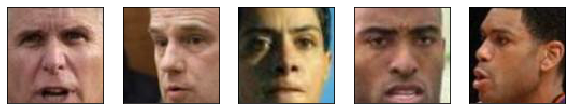

Val photos:


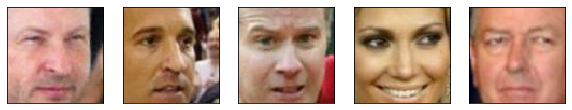

In [0]:
from sklearn.model_selection import train_test_split

# normalize
x = data.astype('float32') / 255.0

# split
x_train, x_val = train_test_split(x, test_size=0.05, random_state=152)

print(x_train[0].shape)

print("Train photos:")
plot_model_outputs(x_train, 5, x_train[0].shape)

print("Val photos:")
plot_model_outputs(x_val, 5, x_val[0].shape)


In [0]:
from __future__ import print_function
from keras.regularizers import l1
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Input, InputLayer, Dense, Activation, BatchNormalization, Dropout, Flatten, Reshape

def build_autoencoder(img_shape, code_size, hidden_size):
  
    # encoder
    encoder = Sequential()  
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(hidden_size*2, activation='relu'))
    encoder.add(BatchNormalization())
    encoder.add(Dropout(0.3))
    encoder.add(Dense(hidden_size, activation='relu'))
    encoder.add(BatchNormalization())
    encoder.add(Dropout(0.3))
    encoder.add(Dense(code_size, activation='relu'))
    
    # decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(hidden_size, activation='relu'))
    decoder.add(BatchNormalization())
    decoder.add(Dropout(0.3))
    decoder.add(Dense(hidden_size*2, activation='relu'))
    decoder.add(BatchNormalization())
    decoder.add(Dropout(0.3))
    decoder.add(Dense(img_shape[0]*img_shape[1]*img_shape[2], activation='sigmoid'))
    decoder.add(Reshape(img_shape))
    
    return encoder, decoder

Using TensorFlow backend.


In [0]:
x = data.astype('float32') / 255.0
img_shape = x.shape[1:]

# split
x_train, x_val = train_test_split(x, test_size=0.05, random_state=152)

# flatten
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

encoder, decoder = build_autoencoder(img_shape, code_size=128, hidden_size=512)
print(encoder.summary())
print(decoder.summary())

W0624 07:09:46.054129 140069608961920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 07:09:46.100344 140069608961920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 07:09:46.131892 140069608961920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 07:09:46.251407 140069608961920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0624 07:09:46.279564 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 24300)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              24884224  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [0]:
'''
inp = Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

for i in range(500):
  autoencoder.fit(x=x_train, y=x_train, epochs=1, batch_size=128,
                  validation_data=[x_val, x_val], verbose=1)
  if i % 5 == 1:
    encoder.save_weights(f'encoder_weights_{i}.txt')
    decoder.save_weights(f'decoder_weights_{i}.txt')
   
  plot_model_outputs(x_val, 5, (90,90,3), autoencoder)
'''  

Output hidden; open in https://colab.research.google.com to view.

In [0]:
inp = Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy')

final_it = 171
encoder.load_weights(f'encoder_weights_{final_it}.txt')
decoder.load_weights(f'decoder_weights_{final_it}.txt')  

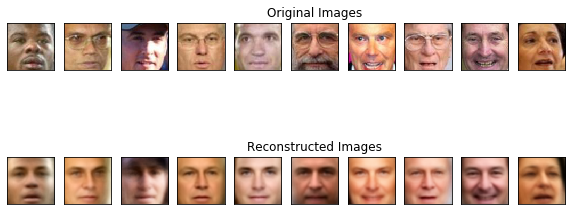

CPU times: user 4.04 s, sys: 41 ms, total: 4.08 s
Wall time: 2.42 s


In [0]:
%%time
plot_model_outputs(x_val, 10, (90,90,3), autoencoder)